# From Scratch

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
PATH = 'imbalanced_cats_and_dogs/'
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 128
IMG_SIZE = (160, 160)
BUFFER_SIZE = BATCH_SIZE*5

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 12000 files belonging to 2 classes.


2022-03-21 14:51:02.349550: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-21 14:51:02.353100: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-21 14:51:02.353195: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-21 14:51:02.353460: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 3000 files belonging to 2 classes.


['cats', 'dog']


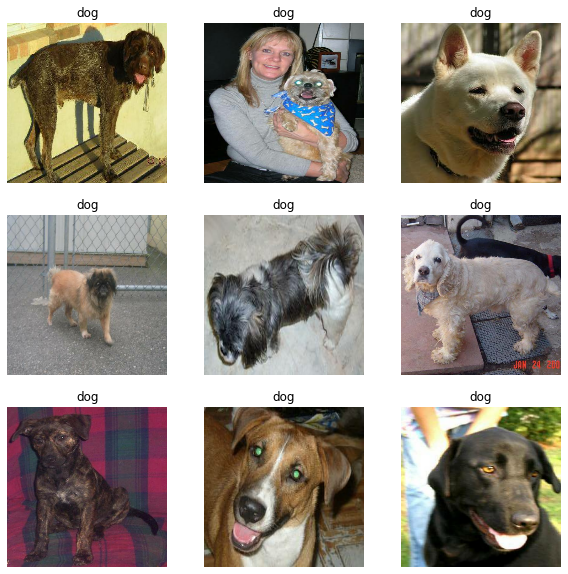

In [4]:
class_names = train_dataset.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
train_dataset = train_dataset.prefetch(buffer_size=BUFFER_SIZE)
validation_dataset = validation_dataset.prefetch(buffer_size=BUFFER_SIZE)

In [6]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

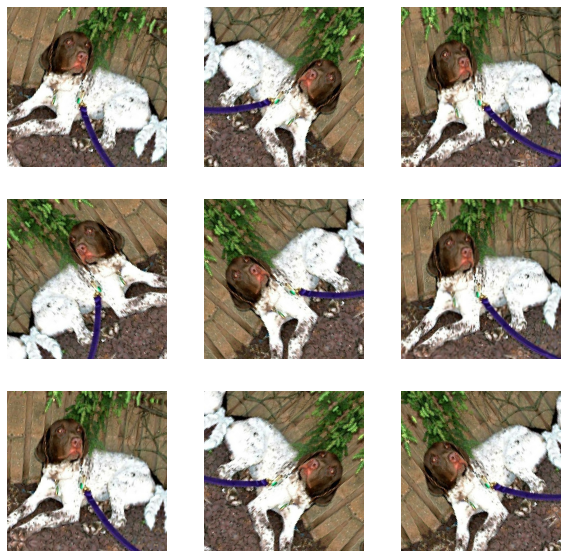

In [7]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [8]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [9]:
print(IMG_SIZE)
IMG_SHAPE = IMG_SIZE + (3,)
print(IMG_SHAPE)

(160, 160)
(160, 160, 3)


In [10]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights=None)

In [11]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2022-03-21 14:51:33.171419: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2022-03-21 14:51:34.240165: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.58GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-03-21 14:51:34.428117: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.53GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-03-21 14:51:34.428158: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.53GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory

(128, 5, 5, 512)


In [12]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(128, 512)


In [13]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(128, 1)


In [14]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x)
x = global_average_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [15]:
base_learning_rate = 0.0001
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(base_learning_rate),
              metrics=METRICS)

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 160, 160, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 160, 160, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                      

In [17]:
len(model.trainable_variables)

28

In [18]:
total = 12000
weight_for_0 = (1 / 1000.0) * (total / 2.0)
weight_for_1 = (1 / 11000.0) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 6.00
Weight for class 1: 0.55


In [19]:
history_fine = model.fit(train_dataset,
                         epochs=50,
                         validation_data=validation_dataset,
                         class_weight=class_weight)

Epoch 1/50


2022-03-21 14:53:21.833572: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.53GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-03-21 14:53:21.833670: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.53GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-03-21 14:53:22.448610: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.53GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-03-21 14:53:22.448684: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Alloc

94/94 [==============================] - 49s 443ms/step - loss: 0.6971 - tp: 6239.0000 - fp: 573.0000 - tn: 427.0000 - fn: 4761.0000 - accuracy: 0.5555 - precision: 0.9159 - recall: 0.5672 - auc: 0.5057 - prc: 0.9199 - val_loss: 0.6929 - val_tp: 1272.0000 - val_fp: 1213.0000 - val_tn: 287.0000 - val_fn: 228.0000 - val_accuracy: 0.5197 - val_precision: 0.5119 - val_recall: 0.8480 - val_auc: 0.5083 - val_prc: 0.5152
Epoch 2/50
94/94 [==============================] - 33s 352ms/step - loss: 0.6823 - tp: 4249.0000 - fp: 295.0000 - tn: 705.0000 - fn: 6751.0000 - accuracy: 0.4128 - precision: 0.9351 - recall: 0.3863 - auc: 0.5597 - prc: 0.9362 - val_loss: 0.6887 - val_tp: 173.0000 - val_fp: 57.0000 - val_tn: 1443.0000 - val_fn: 1327.0000 - val_accuracy: 0.5387 - val_precision: 0.7522 - val_recall: 0.1153 - val_auc: 0.6020 - val_prc: 0.6094
Epoch 3/50
94/94 [==============================] - 33s 352ms/step - loss: 0.6757 - tp: 3528.0000 - fp: 192.0000 - tn: 808.0000 - fn: 7472.0000 - accuracy

94/94 [==============================] - 33s 350ms/step - loss: 0.4297 - tp: 8566.0000 - fp: 176.0000 - tn: 824.0000 - fn: 2434.0000 - accuracy: 0.7825 - precision: 0.9799 - recall: 0.7787 - auc: 0.8813 - prc: 0.9872 - val_loss: 0.5983 - val_tp: 1360.0000 - val_fp: 622.0000 - val_tn: 878.0000 - val_fn: 140.0000 - val_accuracy: 0.7460 - val_precision: 0.6862 - val_recall: 0.9067 - val_auc: 0.8619 - val_prc: 0.8492
Epoch 40/50
94/94 [==============================] - 33s 350ms/step - loss: 0.3938 - tp: 8859.0000 - fp: 149.0000 - tn: 851.0000 - fn: 2141.0000 - accuracy: 0.8092 - precision: 0.9835 - recall: 0.8054 - auc: 0.9030 - prc: 0.9895 - val_loss: 0.4396 - val_tp: 1241.0000 - val_fp: 268.0000 - val_tn: 1232.0000 - val_fn: 259.0000 - val_accuracy: 0.8243 - val_precision: 0.8224 - val_recall: 0.8273 - val_auc: 0.8985 - val_prc: 0.8883
Epoch 41/50
94/94 [==============================] - 33s 350ms/step - loss: 0.4013 - tp: 8838.0000 - fp: 163.0000 - tn: 837.0000 - fn: 2162.0000 - accura

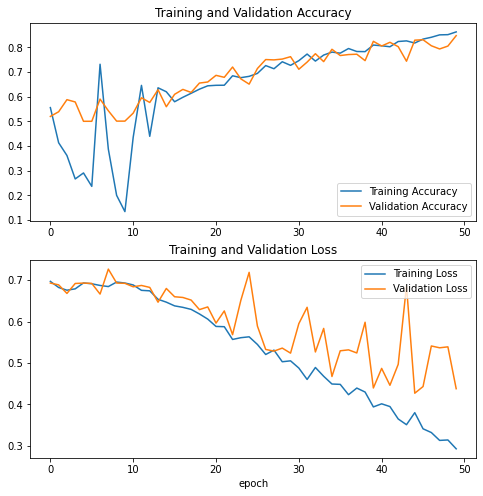

In [20]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [22]:
total_correct_cats = 0
total_correct_dogs = 0
total_correct = 0

for x,y in validation_dataset:    
    output = model.predict(x)
    
    prediction = output > 0.5   
    prediction = tf.dtypes.cast(prediction, tf.int32)
        
    correct_pre = prediction[:,0] == y
    correct_pre = tf.dtypes.cast(correct_pre, tf.int32)
    
    # accumulate
    total_correct = total_correct + tf.math.reduce_sum(correct_pre)
    total_correct_cats = total_correct_cats + tf.math.reduce_sum(correct_pre[y==0])
    total_correct_dogs = total_correct_dogs + tf.math.reduce_sum(correct_pre[y==1])
        
print('total_correct: ', total_correct)
print('total_correct_cats: ', total_correct_cats)
print('total_correct_dogs: ', total_correct_dogs)

total_correct:  tf.Tensor(2542, shape=(), dtype=int32)
total_correct_cats:  tf.Tensor(1163, shape=(), dtype=int32)
total_correct_dogs:  tf.Tensor(1379, shape=(), dtype=int32)
